# Generate propagation raw sequences from songs graphs with and without time metadata  (with date order)


### Import required libraries

In [1]:
import pandas as pd
import os
import numpy as np

from tqdm.notebook import tqdm
import json
import networkx as nx

import matplotlib.pyplot as plt

import math

### Load datasets

In [2]:
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2021_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])
ranking_df.head()

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month
2176,177,Footloose,Kenny Loggins,24993,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,Canada,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,375,1
3392,193,Tequila,Dan + Shay,23917,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,Canada,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,381,1
3594,195,Mine,Bazzi,23780,6tHWl8ows5JOZq9Yfaqn3M,2018-01-18,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,382,1
3772,173,Mine,Bazzi,26500,6tHWl8ows5JOZq9Yfaqn3M,2018-01-19,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,383,1
3978,179,Mine,Bazzi,24577,6tHWl8ows5JOZq9Yfaqn3M,2018-01-20,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,384,1


In [3]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [4]:
ranking_df = ranking_df[ranking_df['Region']!='World']

In [5]:
ranking_df['Region'].unique()

array(['Canada', 'Switzerland', 'Chile', 'Columbia', 'CostaRica',
       'CzechRepublic', 'Germany', 'Denmark', 'DominicanRepublic',
       'Ecuador', 'Estonia', 'Spain', 'Finland', 'France',
       'UnitedKingdom', 'Greece', 'Guatemala', 'HongKong', 'Honduras',
       'Hungary', 'Indonesia', 'Ireland', 'Iceland', 'Italy', 'Japan',
       'Lithuania', 'Luxemborg', 'Latvia', 'Mexico', 'Malaysia',
       'Netherlands', 'Norway', 'NewZealand', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Paraguay', 'Sweden',
       'Singapore', 'Slovakia', 'ElSalvador', 'Turkey', 'Taiwan', 'USA',
       'Uruguay'], dtype=object)

In [6]:
country_dict = {'ar':'Argentina', 'at':'Austria', 'au':'Australia', 'be':'Belgium',
               'bo':'Bolivia', 'br':'Brazil', 'ca':'Canada', 'ch':'Switzerland', 
               'cl':'Chile', 'co':'Columbia', 'cr':'CostaRica', 'cz':'CzechRepublic',
               'de':'Germany', 'dk':'Denmark', 'do':'DominicanRepublic', 'ec':'Ecuador', 
               'ee':'Estonia', 'es':'Spain', 'fi':'Finland', 'fr':'France', 
               'gb':'UnitedKingdom', 'global':'World', 'gr':'Greece', 'gt':'Guatemala',
               'hk':'HongKong', 'hn':'Honduras', 'hu':'Hungary', 'id':'Indonesia', 
               'ie':'Ireland', 'is':'Iceland', 'it':'Italy', 'jp':'Japan', 
               'lt':'Lithuania', 'lu':'Luxemborg', 'lv':'Latvia', 'mx':'Mexico', 
               'my':'Malaysia', 'nl':'Netherlands', 'no':'Norway', 'nz':'NewZealand', 
               'pa':'Panama', 'pe':'Peru', 'ph':'Philippines', 'pl':'Poland', 
               'pt':'Portugal', 'py':'Paraguay', 'se':'Sweden', 'sg':'Singapore', 
               'sk':'Slovakia', 'sv':'ElSalvador', 'tr':'Turkey', 'tw':'Taiwan', 'us':'USA', 'uy':'Uruguay',
                'ae':'UnitedArabEmirates', 'bg':'Bulgaria', 'by':'Belarus', 'eg':'Egypt', 'il': 'Israel',
               'in': 'India', 'kr': 'Korea', 'kz':'Kazakhstan', 'ma': 'Marocco','ng': 'Nigeria','ni':'Nicaragua',
               'ro':'Romania','ru': 'Russia', 'sa': 'SaudiArabia', 'ua':'Ukraine', 'vn':'Vietnam', 'za':'SouthAfrica'} 

In [7]:
country_to_code = {v: k for k, v in codes_to_country.items()}
country_to_code

{'Argentina': 'ar',
 'Austria': 'at',
 'Australia': 'au',
 'Belgium': 'be',
 'Bolivia': 'bo',
 'Brazil': 'br',
 'Canada': 'ca',
 'Switzerland': 'ch',
 'Chile': 'cl',
 'Columbia': 'co',
 'CostaRica': 'cr',
 'CzechRepublic': 'cz',
 'Germany': 'de',
 'Denmark': 'dk',
 'DominicanRepublic': 'do',
 'Ecuador': 'ec',
 'Estonia': 'ee',
 'Spain': 'es',
 'Finland': 'fi',
 'France': 'fr',
 'UnitedKingdom': 'gb',
 'World': 'global',
 'Greece': 'gr',
 'Guatemala': 'gt',
 'HongKong': 'hk',
 'Honduras': 'hn',
 'Hungary': 'hu',
 'Indonesia': 'id',
 'Ireland': 'ie',
 'Iceland': 'is',
 'Italy': 'it',
 'Japan': 'jp',
 'Lithuania': 'lt',
 'Luxemborg': 'lu',
 'Latvia': 'lv',
 'Mexico': 'mx',
 'Malaysia': 'my',
 'Netherlands': 'nl',
 'Norway': 'no',
 'NewZealand': 'nz',
 'Panama': 'pa',
 'Peru': 'pe',
 'Philippines': 'ph',
 'Poland': 'pl',
 'Portugal': 'pt',
 'Paraguay': 'py',
 'Sweden': 'se',
 'Singapore': 'sg',
 'Slovakia': 'sk',
 'ElSalvador': 'sv',
 'Turkey': 'tr',
 'Taiwan': 'tw',
 'USA': 'us',
 'Urugua

We are going to use the country codes for the sequences generation instead the verbose ones

In [8]:
ranking_df['Region_code'] = ranking_df['Region'].apply(lambda r: country_to_code[r])

In [9]:
ranking_df[ranking_df['song_id']=='4nK5YrxbMGZstTLbvj6Gxw']

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month,week_of_study,Region_code
158365,166,Supalonely,"BENEE, Gus Dapperton",34940,4nK5YrxbMGZstTLbvj6Gxw,2020-03-03,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1157,11,165,ca
158510,111,Supalonely,"BENEE, Gus Dapperton",43783,4nK5YrxbMGZstTLbvj6Gxw,2020-03-04,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1158,11,165,ca
158671,72,Supalonely,"BENEE, Gus Dapperton",54370,4nK5YrxbMGZstTLbvj6Gxw,2020-03-05,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1159,11,165,ca
158876,77,Supalonely,"BENEE, Gus Dapperton",64138,4nK5YrxbMGZstTLbvj6Gxw,2020-03-06,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1160,11,165,ca
159064,65,Supalonely,"BENEE, Gus Dapperton",68269,4nK5YrxbMGZstTLbvj6Gxw,2020-03-07,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1161,11,165,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179893,198,Supalonely,"BENEE, Gus Dapperton",1581,4nK5YrxbMGZstTLbvj6Gxw,2020-06-22,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1268,11,181,uy
180089,194,Supalonely,"BENEE, Gus Dapperton",1532,4nK5YrxbMGZstTLbvj6Gxw,2020-06-23,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1269,11,181,uy
181284,189,Supalonely,"BENEE, Gus Dapperton",1570,4nK5YrxbMGZstTLbvj6Gxw,2020-06-29,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1275,11,182,uy
181491,196,Supalonely,"BENEE, Gus Dapperton",1390,4nK5YrxbMGZstTLbvj6Gxw,2020-06-30,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1276,11,182,uy


In [10]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1072803 entries, 2176 to 249493
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Position       1072803 non-null  int64         
 1   Track Name     1072803 non-null  object        
 2   Artist         1072803 non-null  object        
 3   Streams        1072803 non-null  int64         
 4   URL            1072803 non-null  object        
 5   Date           1072803 non-null  datetime64[ns]
 6   Region         1072803 non-null  object        
 7   song_id        1072803 non-null  object        
 8   release_date   1072803 non-null  datetime64[ns]
 9   day_of_study   1072803 non-null  int64         
 10  release_month  1072803 non-null  int64         
 11  week_of_study  1072803 non-null  int64         
 12  Region_code    1072803 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 114.6+ MB


In [11]:
total_songs = ranking_df['song_id'].nunique()
print(f'The number of total songs is {total_songs}')

The number of total songs is 3577


### Auxiliary functions

In [12]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [13]:
def get_paths_from_graph(df, cutoff_=10):
    
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())

    roots = []
    leaves = []
    for node in G.nodes:
        if G.in_degree(node) == 0 : # it's a root
            roots.append(node)
        elif G.out_degree(node) == 0 : # it's a leaf
                leaves.append(node)
    
    paths = []
    for root in roots :
        for leaf in leaves :
            for path in nx.all_simple_paths(G, root, leaf, cutoff= cutoff_):
                paths.append(path)

    return paths

### Generate sequences from graph

We calculate the maximum value between two countries

In [14]:
def generate_sequences_fn(min_link_val, n_day_lags_):
    
    all_paths= []
    all_paths_dates_= {}
    weight_coeff_= int(n_day_lags_/2)
    
    days_difference_dict = {}
    days_difference_with_seq_dict = {}

    for s in tqdm(ranking_df['song_id'].unique()):
         #print('-------------',s)

        country_songs = set()
        all_countries = set()
        prev_origins = set()

        song_ranking= ranking_df[ranking_df['song_id']==s]
        dates=song_ranking.groupby('Region_code')['Date'].min().to_frame()
        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()

        src_lst = []
        target_lst = []
        weight_lst = []

        num_countries_at_d = -1

        prev_day = None
        prev_day_seq = None
        for d in dates_lst:
            
            if prev_day is None:
                prev_day = d
            else:
                d_diff_ = (d-prev_day).days
                v = days_difference_dict.get(d_diff_, 0)
                v += 1
                days_difference_dict[d_diff_] =v
                
                

            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region_code'].unique())

            num_countries_at_d = len(countries_at_d)

            # We only use as origins countries that have not act as origin so far.
            o_countries = list((country_songs.intersection(countries_at_d))-prev_origins)
            d_countries = countries_at_d-country_songs

            #print(f'date: {d.strftime("%d-%m-%Y")}')

            link_values =[]
            for oc in o_countries:
                init_week = song_ranking[song_ranking['Region_code']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region_code']==oc]['Date'].min()

                curr_week = song_ranking[(song_ranking['Region_code']==oc) & 
                                         (song_ranking['Date']==d)]['week_of_study'].values[0]

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags_)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags_:
                    init_day = d - timedelta(days_diff)

                country_values = []
                weights = []  
                first_date = True
                #print(f'{oc}, week_diff: {week_diff}')
                for d_curr in daterange(init_day, d+timedelta(1)):
                    rank =song_ranking[(song_ranking['Region_code']==oc) & (song_ranking['Date']==d_curr)]['Position']
                    if not rank.empty:
                        rank_value = rank.values[0]

                        diff_ = (d_curr-d).days
                        weight = math.exp((diff_/weight_coeff_))

                        value_ = weight * (float(rank_value)**-1)
                        country_values.append(value_)
                
                link_value = ((float(week_diff)**-1) * sum(country_values))
                
                if link_value >= min_link_val:
                    for dc in d_countries:
                        if dc not in all_countries:
                            src_lst.append(oc)
                            target_lst.append(dc)
                            weight_lst.append(link_value)


            country_songs = countries_at_d
            all_countries = all_countries.union(countries_at_d)
            prev_origins = prev_origins.union(o_countries)

            graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst}) 
            #if not graph_df.empty:
            #    print(graph_df)
            song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
            
 
            if len(song_paths)>0:
                if prev_day_seq is None:
                    prev_day_seq = d
                else:
                    d_diff_ = (d-prev_day_seq).days
                    v = days_difference_with_seq_dict.get(d_diff_, 0)
                    v += 1
                    days_difference_with_seq_dict[d_diff_] =v
        
                song_path_lst = []
                for p in song_paths:
                    song_path_lst.append(p)

                date_paths = all_paths_dates_.get(d,{})
                date_paths[s] = song_path_lst
                all_paths_dates_[d] = date_paths

        graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst})

        song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
        for p in song_paths:
            all_paths.append(p)
        #print(all_paths)
    return all_paths_dates_, all_paths, days_difference_dict, days_difference_with_seq_dict

In [15]:
all_paths_dates, all_paths, days_difference_dict, days_difference_with_seq_dict = generate_sequences_fn(0.01, 14)

  0%|          | 0/3577 [00:00<?, ?it/s]

In [16]:
def convert_dict_to_df(dict_):
    data_items = dict_.items()
    data_list = list(data_items)

    df = pd.DataFrame(data_list, columns='diff occurences'.split()).set_index('diff')
    df = df.sort_index()
    df['occurences_rate']= df['occurences']/df.sum().values[0]
    return df

In [17]:
days_difference_df= convert_dict_to_df(days_difference_dict)

In [18]:
days_difference_df.head()

,occurences,occurences_rate
diff,,
1,1141,0.131482
2,341,0.039295
3,293,0.033764
4,232,0.026734
5,212,0.024430


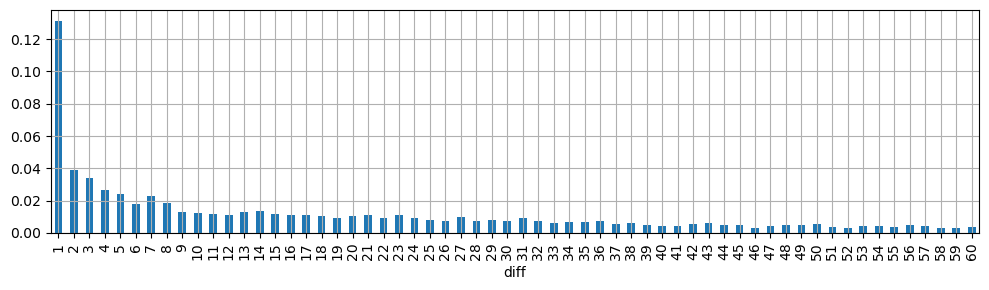

In [19]:
days_difference_df['occurences_rate'].loc[:60].plot(kind='bar', grid=True, figsize=(10,3))
plt.tight_layout()
plt.show()

In [20]:
days_difference_df['occurences_rate'].loc[:14].sum()

0.390758239225628

In [21]:
seq_days_difference_df= convert_dict_to_df(days_difference_with_seq_dict)

In [22]:
seq_days_difference_df.head()

,occurences,occurences_rate
diff,,
1,284,0.069489
2,177,0.043308
3,152,0.037191
4,146,0.035723
5,105,0.025691


In [28]:
seq_days_difference_df.tail()

,occurences,occurences_rate
diff,,
983,1,0.000245
989,1,0.000245
1013,1,0.000245
1016,1,0.000245
1079,1,0.000245


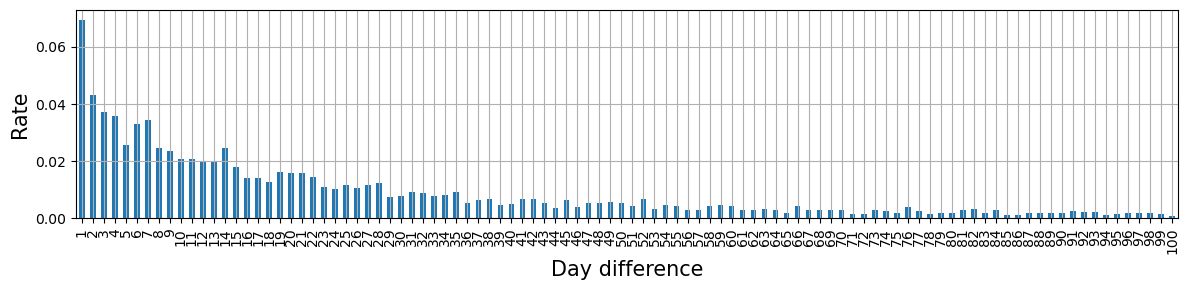

In [44]:
ax= seq_days_difference_df['occurences_rate'].loc[:100].plot(kind='bar', grid=True, figsize=(12,3))
ax.set_xlabel('Day difference', fontsize=15)
ax.set_ylabel('Rate', fontsize=15)

plt.tight_layout()
plt.show()

In [33]:
seq_days_difference_df['occurences_rate'].loc[:14].sum()

0.4328358208955224

In [24]:
print("That's all folks!")

That's all folks!
